Homework: Python and Web Scraper

Christian Schroeder

dbn5du@virginia.edu

Sources:

- How to Webscrape: https://first-web-scraper.readthedocs.io/en/latest/#act-3-web-scraping
- NOAA’s National Data Buoy Center’s Realtime Data: https://www.ndbc.noaa.gov/data/realtime2/
- NOAA NDBC Measurement Description and Units: https://www.ndbc.noaa.gov/measdes.shtml


Import Libraries

In [10]:
import requests 
from bs4 import BeautifulSoup 
import pandas as pd
import plotly.express as px
import numpy as np

Use requests.get() to get the table of files available from NOAA

In [11]:
# Set the URL and save the html text as response
URL = 'https://www.ndbc.noaa.gov/data/realtime2/'
response = requests.get(URL, headers={'User-Agent': 'Mozilla/5.0'})
soup = BeautifulSoup(response.content)

Find all html "a" tags, and then sort them into two lists of files, ocean_data and solar_data. This creates two directories of the available files for ocean condition data and solar radiation data.

In [12]:
# find all html 'a' tags
records = soup.select('a')

# filter records for filenames with extention, '.ocean'
ocean_data = []
for record in records:
    if '.ocean' in record.text: 
        ocean_data.append(record.text)

# filter records for filenames with extention, '.srad'
solar_data = []
for record in records:
    if '.srad' in record.text: 
        solar_data.append(record.text)

Create arrays of the data contained in each file. This opens each file using their URL, then copies all the text on the page into the array, effectively concatenating all the data into two arrays.

In [13]:
# for each file with .ocean extension, save its raw data into the array
ocean = []
for file in ocean_data:
    URL = 'https://www.ndbc.noaa.gov/data/realtime2/' + file
    response = requests.get(URL, headers={'User-Agent': 'Mozilla/5.0'})
    for line in response.text.splitlines()[2:]:
        line = line.split()
        ocean.append(line)

# for each file with .srad extension, save its raw data into the array
solar = []
for file in solar_data:
    URL = 'https://www.ndbc.noaa.gov/data/realtime2/'+ file
    response = requests.get(URL, headers={'User-Agent': 'Mozilla/5.0'})
    for line in response.text.splitlines()[2:]:
        line = line.split()
        solar.append(line)

Convert the arrays into two dataframes using Pandas. Then clean up the dataframes by removing unwanted columns, creating a datetime column, removing 'MM' values (missed measurements), and setting the index.

In [14]:
# convert arrays into dataframes
ocean_df = pd.DataFrame(ocean, columns = ['YY','MM','DD','hh','mm','DEPTH','OTMP','COND','SAL','O2%','O2PPM','CLCON','TURB','PH','EH'])
solar_df = pd.DataFrame(solar, columns = ['YY','MM','DD','hh','mm','SRAD1','SWRAD','LWRAD'])

# create datetime column to later be used for indexing, averaging, and merging
ocean_df['TimeSeries'] = pd.to_datetime(ocean_df['YY'].astype(str)+'-'+ocean_df['MM'].astype(str)+'-'+ocean_df['DD'].astype(str)+'-'+ocean_df['hh'].astype(str))
solar_df['TimeSeries'] = pd.to_datetime(solar_df['YY'].astype(str)+'-'+solar_df['MM'].astype(str)+'-'+solar_df['DD'].astype(str)+'-'+solar_df['hh'].astype(str))

# drop unwanted columns of data
ocean_df = ocean_df.drop(columns=['YY','MM','DD','hh','mm','COND','O2%','O2PPM','CLCON','TURB','PH','EH'], axis=1)
solar_df = solar_df.drop(columns=['SRAD1'], axis=1)

# replace all 'MM' values with NaN, then use that to remove all rows with a NaN value
ocean_df = ocean_df.replace('MM', np.nan).dropna(axis = 0, how = 'any')
solar_df = solar_df.replace('MM', np.nan).dropna(axis = 0, how = 'any')

# set the indexes for each dataframe to the datetime column
ocean_df = ocean_df.set_index('TimeSeries')
solar_df = solar_df.set_index('TimeSeries')

Shorten the dataframes by averaging all the values by the datetime column (by hour)

In [15]:
# make sure all columns are numeric datatypes
ocean_df[['DEPTH','OTMP','SAL']] = ocean_df[['DEPTH','OTMP','SAL']].apply(pd.to_numeric, errors='coerce', axis=1)
solar_df[['SWRAD','LWRAD']]      = solar_df[['SWRAD','LWRAD']].apply(pd.to_numeric, errors='coerce', axis=1)

# average the data by the hour
ocean_df_mean = ocean_df.groupby('TimeSeries').mean().reset_index()
solar_df_mean = solar_df.groupby('TimeSeries').mean().reset_index()

Merge the two dataframes into one to make graphing easier

In [16]:
# Merge the ocean and solar data by the timeseries index into one dataframe
ocean_solar = pd.merge(ocean_df_mean,solar_df_mean, how='inner', right_on='TimeSeries', left_on='TimeSeries')

# round the values to the 4th decimal
ocean_solar = ocean_solar.round(4)

Plot the new dataframe. Plotting Ocean Temperature against Depth and using Solar Radiation as the size of the points.

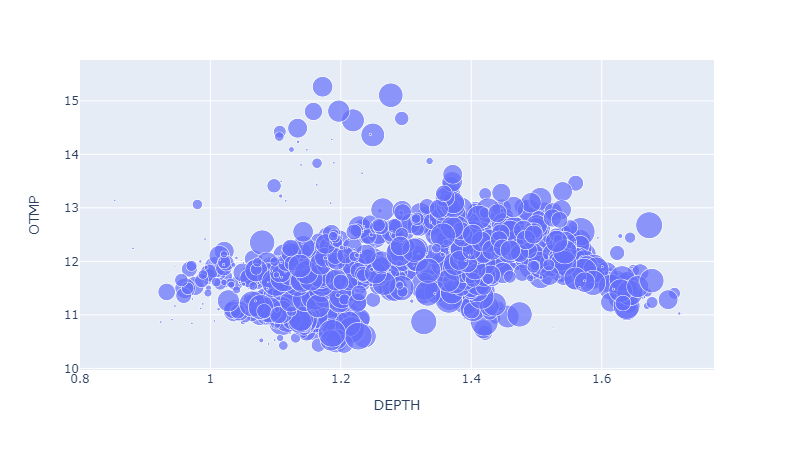

In [17]:
# Plot the data to an interactive scatterplot
ocean_solar['TimeSeries'] = ocean_solar['TimeSeries'].astype(str)
px.scatter(ocean_solar, x="DEPTH", y="OTMP", size="SWRAD")